# Toxic Game: Predicting a DOTA 2 Match Result using Player Data
**Machine Learning 1 Project** <br>
**by James Patrick Verdan**

**Highlights**:
1. Analyzing the case of using feature engineering to a Machine Learning prediction models.
2. Deriving features from the initial features using domain knowledge in order to obtain a different model.
3. Applying different Machine Learning models and hypertuning parameters based on the features.

**Data Source**:<br>
`Dota 2 Matches Dataset`
https://www.kaggle.com/datasets/devinanzelmo/dota-2-matches


In [1]:
# installing modules unavailable in JOJIE
! pip install lightgbm
! pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from tqdm.notebook import trange

import time

import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Introduction

Defense of the Ancient 2 or most commonly known as DOTA 2 Free to Play Multiplayer Online Battle Arena (MOBA) video game developed by Valve Software for Windows and Mac (PC) in 2013. It currently holds the top 5 largest prize pool in e
sports for a single tournament and still has huge number of active players up to date. Another great thing with DOTA 2 is it has a lot of statistics that can be used to predict an outcome of a match. Some of these statistics or feature are gold, experience, kills, deaths, time, etc. However these features tend to be straightforward in predicting the outcomes of a match so it is easy to achieve a close to 100% accuracy. What if we use features that does not directly say which team will win? Enter Feature Engineering:

Feature engineering refers to modifying, creation, removal, combination of features to give another dimension to a dataset which may improve a machine learning model and may lead to better performance, accuracy and interpretability. Feature Engineering gives you a deeper understanding of your data and results in more valuable insights. When done correctly, feature engineering is one of the most valuable techniques of data science. However it is also one of the most challenging since effective feature engineering is based on sound knowledge of the business problem (domain knowledge) and the available data sources.

The motivation behind this report is DOTA 2 has one of the most toxic community in the online game world. So in this report, the application of feature engineering is being highlighted in deriving features related to player behavior, actions, location to predict a match result. 

## Datasets

The dataset contains 50000 ranked matches from the DOTA 2 data dump created by Opendota. It has 11 datasets containing different statistics of players, matches, heroes, items, etc which can enable the exploration of player behavior, skill estimation, or anything you find interesting. For this model, the following data sets are used

`players`: This dataset contains each end of a match statistics of all ten players per match. Example of these are player to hero assignment, gold, experience, kills, deaths, all actions issued to a hero.

`matches`: This dataset contains top level information about each match such as duration of the game, tower and barracks information, game mode, and which team won the game.

`chat`: This dataset contains the All chat for the 50,000 matches. All Chat is defined as a chat message made by either team's players that is visible to both teams. Note that there may be a lot of profanities and harsh language in those chat messages.

`cluster_region` This dataset contains the host server of each match. Server is limited to five regions namely NORTH and SOUTH AMERICA, EUROPE, CHINA and SOUTHEAST ASIA.

`player_ratings`: This dataset contains the computed TrueSkill rating of every player in all the matches which describes the skill level of the player.

In [3]:
data_players=pd.read_csv('./players.csv')
display(data_players.head())
data_matches=pd.read_csv('./match.csv')
display(data_matches.head())
data_chat=pd.read_csv('./chat.csv')
display(data_chat.head())
data_reg=pd.read_csv('./cluster_regions.csv')
display(data_reg.head())
data_ratings=pd.read_csv('./player_ratings.csv', usecols=[0,3])
display(data_ratings.head())

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,unit_order
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,5041
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,8385
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,9167
3,0,2,11,3,1179,22505,599,605,8,4,...,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,6396
4,0,3,67,4,3307,23825,613,762,20,3,...,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,5588


,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


,match_id,key,slot,time,unit
0,0,force it,6,-8,6k Slayer
1,0,space created,1,5,Monkey
2,0,hah,1,6,Monkey
3,0,ez 500,6,9,6k Slayer
4,0,mvp ulti,4,934,Kira


,cluster,region
0,111,NORTH AMERICA
1,112,NORTH AMERICA
2,113,NORTH AMERICA
3,121,NORTH AMERICA
4,122,NORTH AMERICA


,account_id,trueskill_mu
0,236579,27.868035
1,-343,26.544163
2,-1217,26.521103
3,-1227,27.248025
4,-1284,22.931016


## Data Processing

The methodology of this study is as follows: <br>
Feature engineering to derive as much features related to player behavior and actions<br>
Exploratory Data Analysis (EDA) to get initial insight of the data and the features<br>
Dealing with null values<br>
Handling Categorical features<br>
Normalizing values<br>

### Feature Engineering

The main highlight of this report is to create features related to a player behavior that can be derived from the existing datasets. The derived features are as follows: all chat count per team, unit order per team, player rating, and location.

In [4]:
data_chat=pd.read_csv('./chat.csv', usecols=[0,1,2])

# Unifying the player slot per team in preparation to grouping the features per team
player_slot = {0: 0,
               1: 1,
               2: 2,
               3: 3,
               4: 4,
            5 : 128,
           6 : 129,
           7 : 130,
           8 :131,
           9 : 132,
           -9 : 132,}

data_chat["player_slot"] = data_chat["slot"].map(player_slot)
data_chatlist = data_chat.groupby(['match_id', 'player_slot'])['key'].apply(list).reset_index()
data_chatlist["chat_freq"] = data_chatlist['key'].apply(len)
data_chatlist["type_count"] = [''.join(map(str, l)) for l in data_chatlist['key']]
data_chatlist["type_count"] = data_chatlist["type_count"].apply(len)
data_chatlist

,match_id,player_slot,key,chat_freq,type_count
0,0,0,"[fuck my ass, ka bu tooooooooooooo, 6k slayer,...",4,44
1,0,1,"[space created, hah, hah, wtf, TA?, u srsly?, ...",16,98
2,0,2,"[lol, really ?]",2,11
3,0,4,[mvp ulti],1,8
4,0,129,"[force it, ez 500, bye, fate, is cruel, sad sp...",18,195
...,...,...,...,...,...
303910,49999,3,"[G, medusa, wait for medusa, fuck we wait, for...",5,49
303911,49999,128,"[G, 1 punch man]",2,12
303912,49999,129,[ggwp],1,4
303913,49999,130,"[hahaha, we end, no time, noob, booo, Hahahaha]",6,35


All Chat features is derived into two features: chat frequency which is the number of a player's message in a game, and type count which the total number of characters those message contains. Since DOTA 2 is a fast paced game, chat messages are usually short and can even contain one or two characters. However there are instances when players type a long message to point out a specific thought.

In [5]:
data_players = data_players.merge(data_chatlist, on=['match_id', 'player_slot'], how='left')
# Null values are being set to 0 since this means that no all chat was made by that player
data_players['chat_freq'] = data_players['chat_freq'].replace(np.nan,0)
data_players['type_count'] = data_players['type_count'].replace(np.nan,0)

In [6]:
data_players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,unit_order,key,chat_freq,type_count
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,NaN,NaN,NaN,NaN,5041,"[fuck my ass, ka bu tooooooooooooo, 6k slayer,...",4.0,44.0
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,NaN,NaN,NaN,NaN,8385,"[space created, hah, hah, wtf, TA?, u srsly?, ...",16.0,98.0
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,9167,"[lol, really ?]",2.0,11.0
3,0,2,11,3,1179,22505,599,605,8,4,...,NaN,NaN,NaN,NaN,NaN,NaN,6396,NaN,0.0,0.0
4,0,3,67,4,3307,23825,613,762,20,3,...,NaN,NaN,NaN,NaN,NaN,NaN,5588,[mvp ulti],1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,...,NaN,NaN,NaN,NaN,NaN,NaN,5426,"[G, 1 punch man]",2.0,12.0
499996,49999,0,9,129,3755,20815,507,607,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,5701,[ggwp],1.0,4.0
499997,49999,0,90,130,1059,16225,371,404,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,5829,"[hahaha, we end, no time, noob, booo, Hahahaha]",6.0,35.0
499998,49999,0,73,131,3165,31015,780,703,8,6,...,NaN,NaN,NaN,NaN,NaN,NaN,5776,"[go nc, furion nc, noob, happu def noob, ez, e...",15.0,54.0


In [7]:
# grouping the hero_id per team in order to separate the counts of the derive features per team
dire_data = data_players.groupby('match_id')['hero_id'].apply(list)
radiant_data = pd.DataFrame()
for j in range(dire_data.shape[0]):
        new_r = []
        for i in range(5):
            new_r.append(dire_data[j].pop(dire_data[j].index(dire_data[j][0])))
        dictionnar={"Radiant_team":[new_r]}
        radiant_data=pd.concat([radiant_data, pd.DataFrame(dictionnar)], ignore_index=True)
data_matchall = data_matches
data_matchall=data_matchall.drop(columns=['start_time','game_mode','positive_votes','negative_votes', 'first_blood_time'])
data_matchall['radiant_team']=radiant_data
data_matchall['dire_team']=dire_data
data_matchall

,match_id,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,radiant_win,cluster,radiant_team,dire_team
0,0,2375,1982,4,3,63,True,155,"[86, 51, 83, 11, 67]","[106, 102, 46, 7, 73]"
1,1,2582,0,1846,63,0,False,154,"[7, 82, 71, 39, 21]","[73, 22, 5, 67, 106]"
2,2,2716,256,1972,63,48,False,132,"[51, 109, 9, 41, 27]","[38, 7, 10, 12, 85]"
3,3,3085,4,1924,51,3,False,191,"[50, 44, 32, 26, 39]","[78, 19, 31, 40, 47]"
4,4,1887,2047,0,0,63,True,156,"[8, 39, 55, 87, 69]","[101, 100, 22, 67, 21]"
...,...,...,...,...,...,...,...,...,...,...
49995,49995,3025,1824,0,0,63,True,111,"[73, 86, 21, 20, 14]","[32, 7, 109, 35, 112]"
49996,49996,1451,1982,384,48,63,True,204,"[93, 74, 100, 32, 85]","[36, 1, 112, 60, 71]"
49997,49997,2672,1830,0,0,63,True,111,"[100, 68, 75, 39, 44]","[28, 102, 21, 9, 23]"
49998,49998,2211,1982,4,3,63,True,151,"[56, 50, 2, 72, 30]","[46, 7, 29, 44, 3]"


In [8]:
features=['chat_freq', 'type_count', 'unit_order']

# Getting total values per team per feature
for feature in features:
    dire_feat = data_players.groupby('match_id')[feature].apply(list)
    radiant_feat = pd.DataFrame()
    for j in range(dire_feat.shape[0]):
            new_r = [] 
            for i in range(5):
                new_r.append(dire_feat[j].pop(dire_feat[j].index(dire_feat[j][0])))
            dictionnar = {"radiant_team":[new_r]}
            radiant_feat=pd.concat([radiant_feat, pd.DataFrame(dictionnar)], ignore_index=True)
    radiant_feature = radiant_feat['radiant_team'].apply(lambda x : sum(x))
    dire_feature = dire_feat.apply(lambda x :sum(x))
    data_matchall[feature + '_radiant'] = radiant_feature
    data_matchall[feature + '_dire'] = dire_feature
data_matchall

,match_id,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,radiant_win,cluster,radiant_team,dire_team,chat_freq_radiant,chat_freq_dire,type_count_radiant,type_count_dire,unit_order_radiant,unit_order_dire
0,0,2375,1982,4,3,63,True,155,"[86, 51, 83, 11, 67]","[106, 102, 46, 7, 73]",23.0,28.0,161.0,352.0,34577,39155
1,1,2582,0,1846,63,0,False,154,"[7, 82, 71, 39, 21]","[73, 22, 5, 67, 106]",11.0,5.0,100.0,34.0,22431,44294
2,2,2716,256,1972,63,48,False,132,"[51, 109, 9, 41, 27]","[38, 7, 10, 12, 85]",24.0,21.0,238.0,197.0,33147,33560
3,3,3085,4,1924,51,3,False,191,"[50, 44, 32, 26, 39]","[78, 19, 31, 40, 47]",11.0,14.0,49.0,145.0,25208,27743
4,4,1887,2047,0,0,63,True,156,"[8, 39, 55, 87, 69]","[101, 100, 22, 67, 21]",3.0,4.0,13.0,36.0,20707,34781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,3025,1824,0,0,63,True,111,"[73, 86, 21, 20, 14]","[32, 7, 109, 35, 112]",19.0,6.0,185.0,66.0,29704,44788
49996,49996,1451,1982,384,48,63,True,204,"[93, 74, 100, 32, 85]","[36, 1, 112, 60, 71]",1.0,4.0,5.0,45.0,18080,15315
49997,49997,2672,1830,0,0,63,True,111,"[100, 68, 75, 39, 44]","[28, 102, 21, 9, 23]",3.0,4.0,23.0,26.0,30102,34876
49998,49998,2211,1982,4,3,63,True,151,"[56, 50, 2, 72, 30]","[46, 7, 29, 44, 3]",14.0,11.0,140.0,166.0,24904,23854


In [9]:
ratings = data_players.merge(data_ratings, how='left')
ratings['rating'] = ratings['trueskill_mu'].fillna(ratings.groupby('match_id')['trueskill_mu'].transform('mean'))
dire_feat = ratings.groupby('match_id')['rating'].apply(list)
radiant_feat = pd.DataFrame()
for j in range(dire_feat.shape[0]):
        new_r = [] 
        for i in range(5):
            new_r.append(dire_feat[j].pop(dire_feat[j].index(dire_feat[j][0])))
        dictionnar = {"radiant_team":[new_r]}
        radiant_feat=pd.concat([radiant_feat, pd.DataFrame(dictionnar)], ignore_index=True)
radiant_feature = radiant_feat['radiant_team'].apply(lambda x : list(x))
dire_feature = dire_feat.apply(lambda x :list(x))
data_matchall['rating_radiant'] = radiant_feature
data_matchall['rating_dire'] = dire_feature
data_matchall['rating_std_radiant'] = data_matchall['rating_radiant'].apply(lambda x : np.std(x))
data_matchall['rating_std_dire'] = data_matchall['rating_dire'].apply(lambda x : np.std(x))
data_matchall = data_matchall.merge(data_reg, on=['cluster'], how='left')
data_matchall

,match_id,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,radiant_win,cluster,radiant_team,dire_team,...,chat_freq_dire,type_count_radiant,type_count_dire,unit_order_radiant,unit_order_dire,rating_radiant,rating_dire,rating_std_radiant,rating_std_dire,region
0,0,2375,1982,4,3,63,True,155,"[86, 51, 83, 11, 67]","[106, 102, 46, 7, 73]",...,28.0,161.0,352.0,34577,39155,"[25.0, 26.232905478885414, 25.0, 27.6145048216...","[26.77330187539367, 25.0, 32.19055101505015, 2...",2.490819,4.004111,SOUTHEAST ASIA
1,1,2582,0,1846,63,0,False,154,"[7, 82, 71, 39, 21]","[73, 22, 5, 67, 106]",...,5.0,100.0,34.0,22431,44294,"[25.0, 29.49660365641969, 25.0, 18.07127957302...","[27.24786408629859, 25.0, 25.0, 32.19055101505...",3.775828,2.790705,SOUTHEAST ASIA
2,2,2716,256,1972,63,48,False,132,"[51, 109, 9, 41, 27]","[38, 7, 10, 12, 85]",...,21.0,238.0,197.0,33147,33560,"[26.156925036998494, 28.02845249486076, 28.028...","[25.0, 25.0, 25.0, 25.0, 25.0]",1.541538,0.000000,EUROPE
3,3,3085,4,1924,51,3,False,191,"[50, 44, 32, 26, 39]","[78, 19, 31, 40, 47]",...,14.0,49.0,145.0,25208,27743,"[23.856201249857456, 25.0, 25.0, 23.8400709580...","[28.62007229337861, 25.0, 23.55661010673101, 2...",2.453707,2.409592,EUROPE
4,4,1887,2047,0,0,63,True,156,"[8, 39, 55, 87, 69]","[101, 100, 22, 67, 21]",...,4.0,13.0,36.0,20707,34781,"[25.0, 28.47198596887217, 27.645658014236112, ...","[26.205883255763656, 26.28498290722291, 25.0, ...",2.008455,2.571840,SOUTHEAST ASIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,3025,1824,0,0,63,True,111,"[73, 86, 21, 20, 14]","[32, 7, 109, 35, 112]",...,6.0,185.0,66.0,29704,44788,"[25.0, 25.0, 25.0, 25.0, 24.729095869164688]","[25.0, 22.37947562592725, 25.45329132739025, 2...",0.108362,1.091523,NORTH AMERICA
49996,49996,1451,1982,384,48,63,True,204,"[93, 74, 100, 32, 85]","[36, 1, 112, 60, 71]",...,4.0,5.0,45.0,18080,15315,"[28.46492996827109, 26.608249878930543, 35.550...","[25.0, 23.072098142837984, 25.0, 22.7916605069...",3.752688,1.017042,SOUTH AMERICA
49997,49997,2672,1830,0,0,63,True,111,"[100, 68, 75, 39, 44]","[28, 102, 21, 9, 23]",...,4.0,23.0,26.0,30102,34876,"[25.0, 28.7209468178298, 26.196175254588137, 2...","[24.10130159226533, 28.202013939668863, 26.196...",1.445037,1.374177,NORTH AMERICA
49998,49998,2211,1982,4,3,63,True,151,"[56, 50, 2, 72, 30]","[46, 7, 29, 44, 3]",...,11.0,140.0,166.0,24904,23854,"[23.054222108146377, 26.88074474887652, 25.0, ...","[25.0, 23.059191903667557, 23.85070204089284, ...",1.864004,2.054487,SOUTHEAST ASIA


Standard Deviation was used for player rating since ranked matches are set up to have the team in equal playing field. This means that the average player rating of both teams should equal or close to equal (This also explains the null values are converted into the average player rating of the match). However there may be instances that a team has a mix of high level and low level players while the other team has five equal level players.

In [10]:
result = {True: 1, # Radiant wins
         False: 0} # Dire wins

data_matchall['Target'] = data_matchall["radiant_win"].map(result)
# Filtering the columns that will not be used for this model
data_matchall = data_matchall[['chat_freq_radiant', 'chat_freq_dire', 'type_count_radiant',
                               'type_count_dire', 'unit_order_radiant', 'unit_order_dire',
                               'rating_std_radiant', 'rating_std_dire', 'region', 'Target']]
data_matchall

,chat_freq_radiant,chat_freq_dire,type_count_radiant,type_count_dire,unit_order_radiant,unit_order_dire,rating_std_radiant,rating_std_dire,region,Target
0,23.0,28.0,161.0,352.0,34577,39155,2.490819,4.004111,SOUTHEAST ASIA,1
1,11.0,5.0,100.0,34.0,22431,44294,3.775828,2.790705,SOUTHEAST ASIA,0
2,24.0,21.0,238.0,197.0,33147,33560,1.541538,0.000000,EUROPE,0
3,11.0,14.0,49.0,145.0,25208,27743,2.453707,2.409592,EUROPE,0
4,3.0,4.0,13.0,36.0,20707,34781,2.008455,2.571840,SOUTHEAST ASIA,1
...,...,...,...,...,...,...,...,...,...,...
49995,19.0,6.0,185.0,66.0,29704,44788,0.108362,1.091523,NORTH AMERICA,1
49996,1.0,4.0,5.0,45.0,18080,15315,3.752688,1.017042,SOUTH AMERICA,1
49997,3.0,4.0,23.0,26.0,30102,34876,1.445037,1.374177,NORTH AMERICA,1
49998,14.0,11.0,140.0,166.0,24904,23854,1.864004,2.054487,SOUTHEAST ASIA,1


In [11]:
data_matchall.columns

Index(['chat_freq_radiant', 'chat_freq_dire', 'type_count_radiant',
       'type_count_dire', 'unit_order_radiant', 'unit_order_dire',
       'rating_std_radiant', 'rating_std_dire', 'region', 'Target'],
      dtype='object')

In [12]:
data_matchall.shape

(50000, 10)

### Exploratory Data Analysis

Population per class:       0
1  25943
0  24057
Proportion Chance Criterion: 50.07%
1.25 * Proportion Chance Criterion: 62.59%


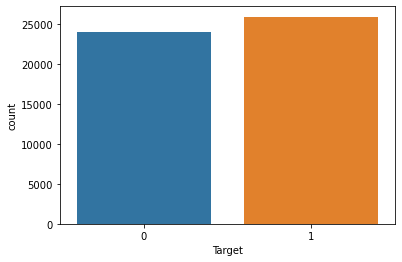

In [13]:
state_counts = Counter(data_matchall['Target'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')

num=(df_state[0]/df_state[0].sum())**2

print("Population per class:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

sns.countplot(x = data_matchall['Target'])
plt.show()

The dataset has a relatively balanced proportion. Since this model is using unconventional features related to DOTA 2, it is expected that the accuracy will not be as high as using features that can easily predict a match result (i.e gold, experience). The basis for a good or bad model will be based on the 1.25 times the proportional chance criterion (.6259).

In [14]:
data_matchall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chat_freq_radiant   50000 non-null  float64
 1   chat_freq_dire      50000 non-null  float64
 2   type_count_radiant  50000 non-null  float64
 3   type_count_dire     50000 non-null  float64
 4   unit_order_radiant  50000 non-null  int64  
 5   unit_order_dire     50000 non-null  int64  
 6   rating_std_radiant  49975 non-null  float64
 7   rating_std_dire     49975 non-null  float64
 8   region              50000 non-null  object 
 9   Target              50000 non-null  int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 4.2+ MB


In [15]:
data_matchall.describe()

,chat_freq_radiant,chat_freq_dire,type_count_radiant,type_count_dire,unit_order_radiant,unit_order_dire,rating_std_radiant,rating_std_dire,Target
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,49975.000000,49975.000000,50000.000000
mean,14.301360,14.488400,152.066500,154.055220,26608.891140,26676.650940,2.030072,2.046378,0.518860
std,15.294349,15.602634,200.866922,204.582623,7581.576194,7742.599025,1.328145,1.343392,0.499649
min,0.000000,0.000000,0.000000,0.000000,633.000000,1391.000000,0.000000,0.000000,0.000000
25%,5.000000,5.000000,33.000000,34.000000,21493.000000,21422.000000,1.031746,1.031435,0.000000
50%,10.000000,10.000000,87.000000,90.000000,25736.000000,25841.000000,1.914322,1.934706,1.000000
75%,18.000000,19.000000,192.000000,196.000000,30658.000000,30957.250000,2.875942,2.911558,1.000000
max,265.000000,363.000000,4536.000000,9221.000000,156492.000000,162852.000000,8.842668,9.000626,1.000000


Dire has higher max number on every feature which can indicate that players assigned to dire are the more active players. For the result, this can also relate to the dire features being the top predictor team compared to radiant. The average and standard deviation of the features are almost similar for both teams with dire having a slight edge.

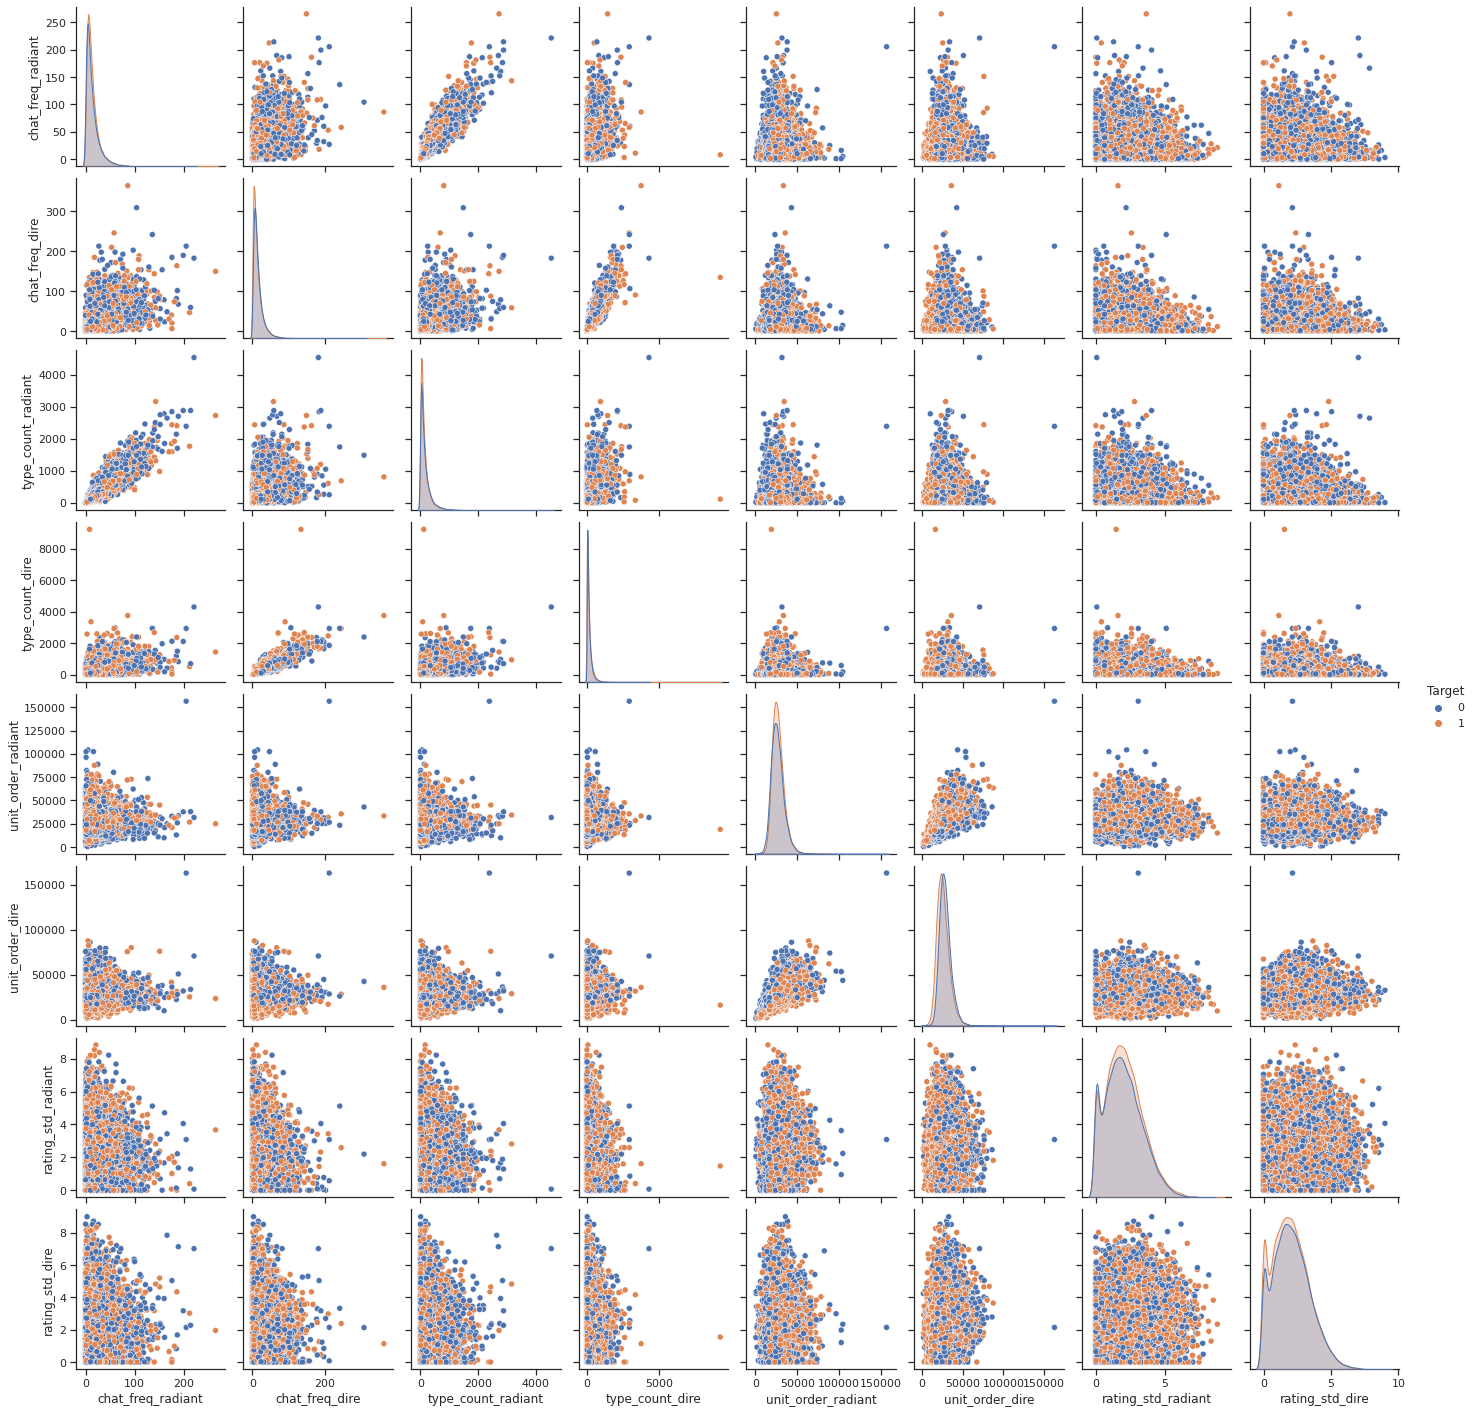

In [16]:
sns.set(style="ticks")
sns.pairplot(data_matchall, hue="Target", diag_kind='kde')

pass

The pair plot shows that no feature can be easily related to the result of a match since results are scattered in every plot. However it can be seen that type count and chat frequency are somewhat colinear which is intuitive. 

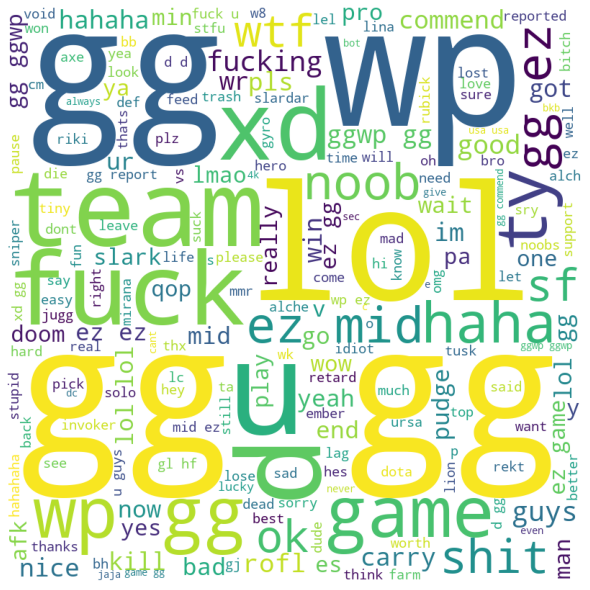

In [17]:
stopwords = set(STOPWORDS)
# extra_stopwords = {'gg'}
# stopwords.update(extra_stopwords)
comment_words = ''
for val in data_chat.key:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
    
wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                normalize_plurals=False,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

The word cloud is a good tool to check the messages of the chats of the players. By eyeballing this word cloud, it can be confirmed that DOTA 2 has a lot of trashtalking messages and high toxicity. This can also be viewed in a way that high message count can relate to a team winning since normally a player that messages the other team is the one leading the game.

### Data Preparation

### Checking for Null Values

In [18]:
data_matchall.isnull().sum()

chat_freq_radiant      0
chat_freq_dire         0
type_count_radiant     0
type_count_dire        0
unit_order_radiant     0
unit_order_dire        0
rating_std_radiant    25
rating_std_dire       25
region                 0
Target                 0
dtype: int64

In [19]:
data_matchall = data_matchall.dropna().reset_index(drop=True)
data_matchall.shape

(49975, 10)

Null values are from the player rating for matches with all ten players having no rating. The said matches are being dropped since there will be no basis of the rating of the match as well as this is only 25 matches compared to the 50,000 total matches.

### Categorical Values

Onehot Encoding of the region feature

In [20]:
X_clean = data_matchall
X_clean = X_clean.drop('Target', axis=1)
X_column_names =X_clean.columns

X_clean=pd.get_dummies(X_clean, drop_first=True)
X_clean.head()

,chat_freq_radiant,chat_freq_dire,type_count_radiant,type_count_dire,unit_order_radiant,unit_order_dire,rating_std_radiant,rating_std_dire,region_EUROPE,region_NORTH AMERICA,region_SOUTH AMERICA,region_SOUTHEAST ASIA
0,23.0,28.0,161.0,352.0,34577,39155,2.490819,4.004111,0,0,0,1
1,11.0,5.0,100.0,34.0,22431,44294,3.775828,2.790705,0,0,0,1
2,24.0,21.0,238.0,197.0,33147,33560,1.541538,0.000000,1,0,0,0
3,11.0,14.0,49.0,145.0,25208,27743,2.453707,2.409592,1,0,0,0
4,3.0,4.0,13.0,36.0,20707,34781,2.008455,2.571840,0,0,0,1


### Normalizing Values

MinMax Scaler was used since it gives the higher accuracy over Standard Scaler

In [21]:
# stdsc = StandardScaler()
# XX = X_clean[['chat_freq_radiant', 'type_count_radiant', 'player_rating']]
# XX_column_names = XX.columns
# XX = stdsc.fit_transform(XX.astype(np.float)) #You will loss the column names
# XX = pd.DataFrame(data=XX, columns=XX_column_names) # Return the column names
# for column in XX_column_names:
#     X_clean[column] = XX[column]
# XX_df = X_clean
# XX_df.head()

MinMaxScaler()
sscaler = MinMaxScaler()
XX = X_clean
XX_column_names = XX.columns
XX = sscaler.fit_transform(XX.astype(np.float))
XX_df = pd.DataFrame(data = XX,columns = XX_column_names)
XX_df.head()

/tmp/ipykernel_298056/964443093.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  XX = sscaler.fit_transform(XX.astype(np.float))


,chat_freq_radiant,chat_freq_dire,type_count_radiant,type_count_dire,unit_order_radiant,unit_order_dire,rating_std_radiant,rating_std_dire,region_EUROPE,region_NORTH AMERICA,region_SOUTH AMERICA,region_SOUTHEAST ASIA
0,0.086792,0.077135,0.035494,0.038174,0.217787,0.233889,0.281682,0.444870,0.0,0.0,0.0,1.0
1,0.041509,0.013774,0.022046,0.003687,0.139857,0.265717,0.427001,0.310057,0.0,0.0,0.0,1.0
2,0.090566,0.057851,0.052469,0.021364,0.208612,0.199237,0.174330,0.000000,1.0,0.0,0.0,0.0
3,0.041509,0.038567,0.010802,0.015725,0.157675,0.163210,0.277485,0.267714,1.0,0.0,0.0,0.0
4,0.011321,0.011019,0.002866,0.003904,0.128796,0.206799,0.227132,0.285740,0.0,0.0,0.0,1.0


In [22]:
XX_df.shape

(49975, 12)

## Machine Learning Methods

All ten models discussed in Machine Learning 1 will be used plus an additional model CATBoost (which is also a type of Gradient Boosting Method) to make it 11-in-1 AutoML. All models are set to run at 10 trials to minimize running time given the large dataset. Random Forest and Gradient Boosting Method (plus its other iterations) hypertuned to only 1 parameter to minimize running time.

In [23]:
def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in trange(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        neighbors_settings = range(1,20)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:   
            clf = KNeighborsClassifier(n_neighbors=n_neighbors) # build the model 
            clf.fit(X_train, y_train)    
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)   
        
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'NA',run_time]

def train_logistic(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear').fit(X_train, y_train)
            if reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False).fit(X_train, y_train)
            
            
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            coefs=lr.coef_ 
            weighted_coefs.append(coefs) #append all the computed coefficients per trial
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials 
    #print(mean_coefs) 
    score = np.mean(score_test, axis=0)
    
    #Plot the weight of the parameters 
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[0,:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
     
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Logistic ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor, run_time]

def train_svm(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.coef_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[0,:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Linear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor,run_time]

def train_RF(X, y, reg):
    max_features_tuning=[0.1, .2, .3, .4, .5, .7, .8]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = RandomForestClassifier(n_estimators=100, max_features=max_features_run).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(score), \
            'Max_features = {0}'.format(max_features_tuning[np.argmax(score)]), top_predictor,run_time]

def train_GBM(X, y, reg):
    max_features_tuning=[0.1, .2, .3, .4, .5, .7, .8]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = GradientBoostingClassifier(max_features=max_features_run).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(score), \
            'Max_features = {0}'.format(max_features_tuning[np.argmax(score)]), top_predictor,run_time]

def train_XGB(X, y):
    max_depth_tuning=[None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_depth in max_depth_tuning:
            svc = XGBClassifier(max_depth=max_depth).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['XGBoost Method', np.amax(score), \
            'Max_depth = {0}'.format(max_depth_tuning[np.argmax(score)]), top_predictor,run_time]

def train_CAT(X, y):
    max_depth_tuning=[None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_depth in max_depth_tuning:
            svc = CatBoostClassifier(n_estimators=100, max_depth=max_depth, silent=True).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['CATBoost Method', np.amax(score), \
            'Max_depth = {0}'.format(max_depth_tuning[np.argmax(score)]), top_predictor,run_time]

def train_LGBM(X, y):
    max_depth_tuning=[None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_depth in max_depth_tuning:
            svc = LGBMClassifier(n_estimators=100, max_depth=max_depth).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['LightGBM Method', np.amax(score), \
            'Max_depth = {0}'.format(max_depth_tuning[np.argmax(score)]), top_predictor,run_time]

def train_ADA(X, y, reg):
    max_features_tuning=[0.1, .2, .3, .4, .5, .7, .8, 0.9]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = AdaBoostClassifier(learning_rate=max_features_run,
                                     n_estimators=100).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['AdaBoost Method', np.amax(score), \
            'Learning_rate = {0}'.format(max_features_tuning[np.argmax(score)]), top_predictor,run_time]


  0%|          | 0/10 [00:00<?, ?it/s]

['kNN', 0.6221546342244277, 'N_Neighbor = 19', 'NA', 1270.3920438289642]
1270.3920438289642 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['Logistic (l2)', 0.6789178805826797, 'C = 100', 'type_count_dire', 392.01686811447144]
392.01686811447144 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['Logistic (l1)', 0.6793901072514807, 'C = 5', 'type_count_dire', 154.87130212783813]
154.87130212783813 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['Linear SVM (l2)', 0.6785096846486313, 'C = 20', 'type_count_dire', 289.8210184574127]
289.8210184574127 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['Linear SVM (l1)', 0.6785577076996958, 'C = 3', 'type_count_dire', 181.1784999370575]
181.1784999370575 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['Random Forest', 0.6922282695693933, 'Max_features = 0.3', 'unit_order_dire', 886.3881616592407]
886.3881616592407 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['Gradient Boosting Method', 0.6968304786297422, 'Max_features = 0.8', 'unit_order_dire', 253.60386157035828]
253.60386157035828 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['CATBoost Method', 0.7076676804866335, 'Max_depth = 4', 'unit_order_dire', 607.4368968009949]
607.4368968009949 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['LightGBM Method', 0.7053785817192252, 'Max_depth = 10', 'type_count_radiant', 942.9038589000702]
942.9038589000702 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['XGBoost Method', 0.7065951656795262, 'Max_depth = 3', 'unit_order_dire', 4372.107265949249]
4372.107265949249 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

['AdaBoost Method', 0.6898591323835441, 'Learning_rate = 0.9', 'unit_order_dire', 328.96021366119385]
328.96021366119385 seconds


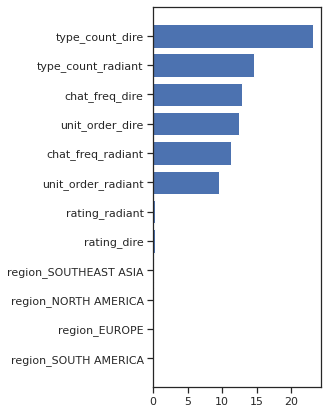

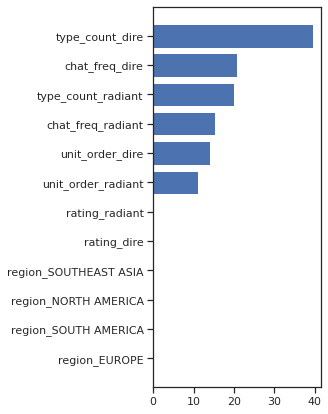

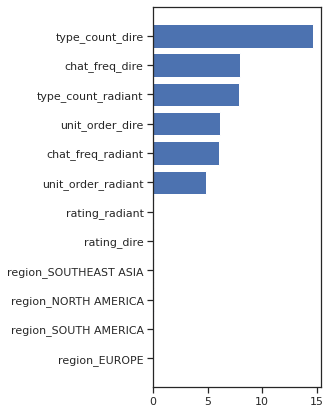

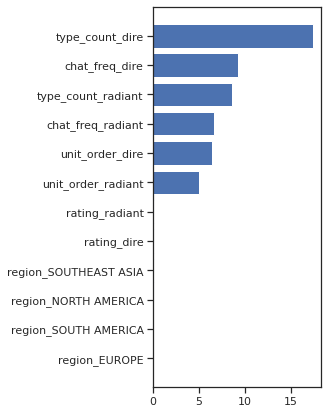

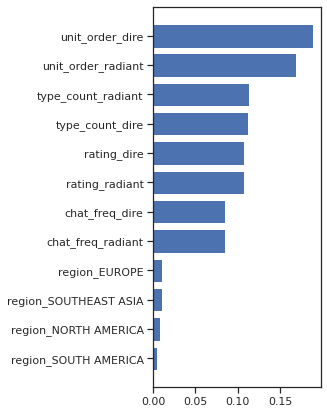

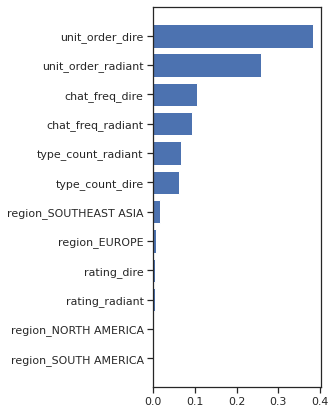

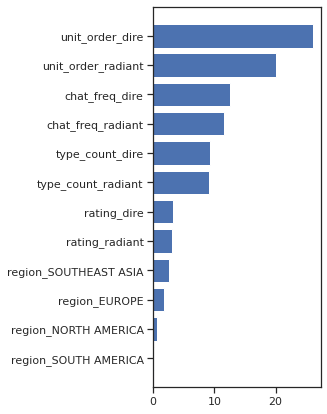

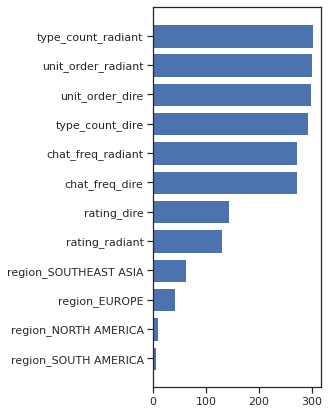

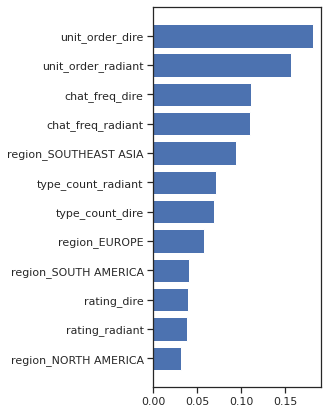

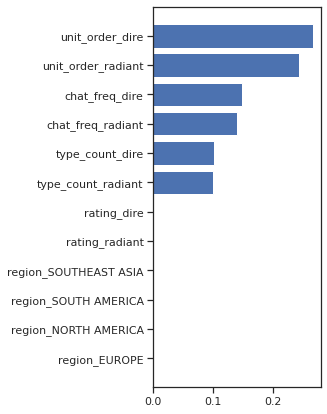

In [63]:
X = XX_df
y = data_matchall['Target']

Number_trials=10

start_time = time.time()
a = train_knn(X,y)
print(a)
print("%s seconds" % a[4])

start_time = time.time()
b = train_logistic(X,y,reg='l2')
print(b)
print("%s seconds" % b[4])

start_time = time.time()
c = train_logistic(X,y,reg='l1')
print(c)
print("%s seconds" % c[4])

start_time = time.time()
d = train_svm(X,y,reg='l2')
print(d)
print("%s seconds" % d[4])

start_time = time.time()
e = train_svm(X,y,reg='l1')
print(e)
print("%s seconds" % e[4])

start_time = time.time()
f = train_RF(X,y,reg='none')
print(f)
print("%s seconds" % f[4])

start_time = time.time()
g = train_GBM(X,y,reg='none')
print(g)
print("%s seconds" % g[4])

start_time = time.time()
h = train_CAT(X,y)
print(h)
print("%s seconds" % h[4])

start_time = time.time()
i = train_LGBM(X,y)
print(i)
print("%s seconds" % i[4])

start_time = time.time()
j = train_XGB(X,y)
print(j)
print("%s seconds" % j[4])

start_time = time.time()
k = train_ADA(X,y,reg='none')
print(k)
print("%s seconds" % k[4])

In [64]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g
df2.loc[7] = h
df2.loc[8] = i
df2.loc[9] = j
df2.loc[10] = k

df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.622155,N_Neighbor = 19,NA,1270.392044
1,Logistic (l2),0.678918,C = 100,type_count_dire,392.016868
2,Logistic (l1),0.679390,C = 5,type_count_dire,154.871302
3,Linear SVM (l2),0.678510,C = 20,type_count_dire,289.821018
4,Linear SVM (l1),0.678558,C = 3,type_count_dire,181.178500
5,Random Forest,0.692228,Max_features = 0.3,unit_order_dire,886.388162
6,Gradient Boosting Method,0.696830,Max_features = 0.8,unit_order_dire,253.603862
7,CATBoost Method,0.707668,Max_depth = 4,unit_order_dire,607.436897
8,LightGBM Method,0.705379,Max_depth = 10,type_count_radiant,942.903859
9,XGBoost Method,0.706595,Max_depth = 3,unit_order_dire,4372.107266


## Feature Importance

Bootstrap is a resampling method that allows us to create a sampling distribution of any kind of statistic. It helps quantify uncertainty or confidence to give a more comprehensive picture of your model results. 

In [23]:
xb = X.to_numpy()
yb = y.to_numpy()
sim_size = 50

feature_importance = []

for i in trange(sim_size):
    
    n = len(xb)
    samp_ind = np.random.choice(range(n), size=n, replace=True)
    x_boot = xb[samp_ind]
    y_boot = yb[samp_ind]
    
    model = CatBoostClassifier(n_estimators=250, max_depth=None, bootstrap_type='Bernoulli',
                               loss_function='CrossEntropy', learning_rate=0.1, silent=True)  #Best model
    model.fit(x_boot, y_boot)
    
    feature_importance.append(model.feature_importances_)
    
feature_importance = np.array(feature_importance)

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
feature_names = X.columns
df_importance = pd.DataFrame({'Feature': feature_names, 'Avg. Importance': feature_importance.mean(axis=0), 'Std. Importance': feature_importance.std(axis=0)}).sort_values(by='Avg. Importance', ascending=False)
df_importance

,Feature,Avg. Importance,Std. Importance
5,unit_order_dire,23.020793,0.661431
4,unit_order_radiant,18.333316,0.473218
1,chat_freq_dire,12.403833,0.423855
0,chat_freq_radiant,11.774728,0.348871
2,type_count_radiant,10.799228,0.299124
3,type_count_dire,10.590838,0.328895
7,rating_std_dire,4.164862,0.291324
6,rating_std_radiant,3.920361,0.278750
11,region_SOUTHEAST ASIA,2.641226,0.207012
8,region_EUROPE,1.547586,0.203695


The results above gives confidence that unit_order is the top predictor given the high importance average and low standard deviation. This is followed by chat frequency and type count respectively. The least important features are the player rating and the player server.

## Results and Discussion

The best model (CATBoost Method) produces a test accuracy of 0.709 which compared to the 1.25Pcc of 0.625, passes. This means that player behavior and actions can be used to predict a result of a DOTA 2 match. Even the other models passed the baseline even if their accuracy is lower than CATBoost. For KNN, it can still be optimized to increase the N-Neighbor (it was limited to 20 in order to minimize running time).

The top predictor being unit order is sensible since a winning team is able to have more map control thus having more commands being issued to their own hero. In non-DOTA 2 terms, a losing team usually gives up easily and tend to not play the game resulting into less commands being issued to the heroes.

All Chat features also has a high importance since winning team messages more in order to express their emotions compared to a losing team which normally discusses the situation internally.

Bootsrap was also used to build confidence on the top predictors of the CATBoost model.

## Conclusion and Recommendation 

This case examines an alternative approach to predicting a DOTA 2 match result via a player's behavior and actions which were derived by way of feature engineering. Yes, there are other features that can be used to maximize the accuracy of the model (using the gold, experience, death, kills can increase the accuracy up to 99%, please refer to this link for the said model https://www.kaggle.com/code/nurbekserzhanov/dota2-ml-model-with-99-accurate). However feature engineering  can give another dimension to a dataset which can give valuable insights that are not apparent with the initial features. Feature engineering is powerful but it is also presents a certain challenge since domain knowledge is crucial in order to produce features that have high impact and can give the correct insights.

Recommendation to improve this study is to double down on feature engineering, better features such as understanding the type of chat, checking the types of unit order, using data on the types of chat (voice lines, chat wheel) a player can make.
Another recommendation is to hypertune the parameters even further as this is one of drawbacks of having a relatively large dataset. Run time to hypertune every parameter will take multiple hours per model.